# CDU: Number of trajets per VIN per day

# Libraries and Data

### Libraries

In [1]:
import pandas as pd
from google.auth import default
from google.cloud import bigquery
from google.cloud import storage
from datetime import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats
from prettytable import PrettyTable
import numpy as np
import seaborn as sns
from datetime import timedelta
from scipy.stats import shapiro
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Loading data from the table on GCP

##### BigQuery Connection

In [2]:
creds, project = default()
creds = creds.with_quota_project(project)

bqclient = bigquery.Client(credentials=creds, project=project)
bqclient = bigquery.Client()

##### Interested BFB trips before filters

In [3]:
%%bigquery df
SELECT vin,model,start_dateTime,end_dateTime,journey_mileage,country_reg
FROM `irn-74856-zlb-lab-c5.labs_victor_de_carvalho_silva.df_c1r1_BFB3`;

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
df.head()

,vin,model,start_dateTime,end_dateTime,journey_mileage,country_reg
0,1101285807510777145,BFB,2020-01-05 13:04:57+00:00,2020-01-05 13:23:11+00:00,20.799999,NL
1,1101285807510777145,BFB,2019-06-05 14:11:50+00:00,2019-06-05 14:44:15+00:00,11.600000,NL
2,1101285807510777145,BFB,2019-05-28 03:30:02+00:00,2019-05-28 03:50:00+00:00,14.900000,NL
3,4774180969458275724,BFB,2020-05-06 16:12:52+00:00,2020-05-06 16:26:44+00:00,13.000000,NL
4,5223580807466725300,BFB,2019-10-18 14:33:43+00:00,2019-10-18 14:54:36+00:00,9.600000,NL


##### Total BFB public on market

This data will be usefull to calculate the Confidence Interval by using the formula for the mean

In [5]:
%%bigquery BFB_TOTAL
SELECT *
FROM `irn-74856-zlb-lab-c5.labs_victor_de_carvalho_silva.BFB_TOTAL`;

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
BFB_TOTAL.head()

,string_field_0,string_field_2,string_field_3
0,VF1RFB00569929251,02.11.2022,01.01.2023
1,VF1RFB00968653582,02.12.2021,01.02.2022
2,VF1RFB00968130482,03.11.2021,01.02.2022
3,VF1RFB00268653360,03.12.2021,01.02.2022
4,VF1RFB00767439907,07.05.2021,01.02.2022


# Data enrichment

##### Converting data format

In [7]:
df['year']=pd.DatetimeIndex(df['start_dateTime']).year
df['month']=pd.DatetimeIndex(df['start_dateTime']).month
df['day']=pd.DatetimeIndex(df['start_dateTime']).day
df['time']=pd.DatetimeIndex(df['start_dateTime']).time
df['duration']=df.end_dateTime-df.start_dateTime

In [8]:
df.describe()

,journey_mileage,year,month,day,duration
count,6.922210e+06,7.582986e+06,7.582986e+06,7.582986e+06,7582986
mean,1.077266e+01,2.019328e+03,6.602519e+00,1.573035e+01,0 days 00:13:43.374258900
std,5.197775e+01,4.693347e-01,3.304006e+00,8.781531e+00,0 days 00:18:26.832247534
min,-5.334300e+04,2.019000e+03,1.000000e+00,1.000000e+00,-1 days +23:59:31
25%,1.000000e+00,2.019000e+03,4.000000e+00,8.000000e+00,0 days 00:03:24
50%,3.700000e+00,2.019000e+03,6.000000e+00,1.600000e+01,0 days 00:08:05
75%,1.090000e+01,2.020000e+03,9.000000e+00,2.300000e+01,0 days 00:17:04
max,1.089643e+05,2.020000e+03,1.200000e+01,3.100000e+01,0 days 22:50:42


##### Definition of data validity conditions and slices

In [9]:
# Conditions
min_dur_trip=timedelta(seconds=60)

is_min_dur_trip = df.duration>min_dur_trip
is_min_length_trip = df.journey_mileage>0.5
is_BFB=df.model=='BFB'

#Boolean variable
is_valid_trip=is_min_dur_trip*is_min_length_trip*is_BFB

#Extraction slice pour les trajets valides
df_valid_trip = pd.DataFrame(df.loc[is_valid_trip])

In [10]:
#df_valid_trip = df_valid_trip[df_valid_trip['country_reg'] == 'GB']

In [11]:
df_valid_trip['end_dateTime'] = pd.to_datetime(df_valid_trip['end_dateTime'])
df_valid_trip['jour'] = df_valid_trip['end_dateTime'].dt.date

In [12]:
trajets_by_VIN_day=df_valid_trip.groupby(by=['vin','jour','country_reg'], as_index=False).agg({'time': pd.Series.nunique})

In [13]:
trajets_by_VIN_day2 = trajets_by_VIN_day

In [14]:
# Convert the 'jour' column to datetime type
trajets_by_VIN_day2['jour'] = pd.to_datetime(trajets_by_VIN_day2['jour'], format='%d/%m/%Y')

# Group values by car and calculate the minimum and maximum dates
car_group = trajets_by_VIN_day2.groupby('vin')
min_date = car_group['jour'].min()
max_date = car_group['jour'].max()

# Calculate the difference in days between the maximum and minimum dates for each group
day_difference = (max_date - min_date).dt.days

# Create new columns in the dataframe with the calculated values
trajets_by_VIN_day2['min'] = trajets_by_VIN_day2['vin'].map(min_date)
trajets_by_VIN_day2['max'] = trajets_by_VIN_day2['vin'].map(max_date)
trajets_by_VIN_day2['dif'] = trajets_by_VIN_day2['vin'].map(day_difference)

In [15]:
dif_days = trajets_by_VIN_day2.drop_duplicates(subset=['vin'])
dif_days = dif_days.drop(['jour', 'time'], axis=1)
dif_days

,vin,country_reg,min,max,dif
0,-1001344942697174424,DE,2019-05-08,2020-05-05,363
249,-1004899524086597306,FR,2019-05-10,2020-05-02,358
450,-1009092623881972018,DE,2019-05-08,2020-05-05,363
684,-1009107883011940973,FR,2019-05-08,2020-05-05,363
995,-1009745513676073246,DE,2019-05-08,2020-05-06,364
...,...,...,...,...,...
1260549,991393084093400983,FR,2019-03-19,2020-03-17,364
1260790,991700077497859955,DE,2019-04-29,2020-04-25,362
1261075,993195718149873653,DE,2019-05-09,2020-05-06,363
1261335,994290589278185538,FR,2019-04-09,2020-04-07,364


##### Treating of 'time' on data

In [16]:
# Using pivot_table to transform the table into the desired format
df_pivot = pd.pivot_table(trajets_by_VIN_day2, values='time', index=['vin'], columns=['jour'], fill_value=0)
df_pivot = df_pivot.reset_index()

In [17]:
df_pivot['somme'] = df_pivot.iloc[:, 1:].sum(axis=1)

In [18]:
complete = df_pivot.merge(dif_days, on='vin', how='inner')

In [19]:
complete['quant'] = complete['somme']/complete['dif']
complete.head()

,vin,2019-03-18 00:00:00,2019-03-19 00:00:00,2019-03-20 00:00:00,2019-03-21 00:00:00,2019-03-22 00:00:00,2019-03-23 00:00:00,2019-03-24 00:00:00,2019-03-25 00:00:00,2019-03-26 00:00:00,...,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00,somme,country_reg,min,max,dif,quant
0,-1001344942697174424,0,0,0,0,0,0,0,0,0,...,0,0,0,0,807,DE,2019-05-08,2020-05-05,363,2.223140
1,-1004899524086597306,0,0,0,0,0,0,0,0,0,...,0,0,0,0,694,FR,2019-05-10,2020-05-02,358,1.938547
2,-1009092623881972018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,679,DE,2019-05-08,2020-05-05,363,1.870523
3,-1009107883011940973,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1066,FR,2019-05-08,2020-05-05,363,2.936639
4,-1009745513676073246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,882,DE,2019-05-08,2020-05-06,364,2.423077


##### Selecting and adjusting just the important columns

In [20]:
frame = complete.iloc[:, [0] + list(range(-6, 0))]

In [21]:
complete = frame.rename(columns={'somme': 'number_of_trips', 'dif': 'number_of_days', 'quant': 'nb_trips_per_vin_day'})
complete.head()

,vin,number_of_trips,country_reg,min,max,number_of_days,nb_trips_per_vin_day
0,-1001344942697174424,807,DE,2019-05-08,2020-05-05,363,2.223140
1,-1004899524086597306,694,FR,2019-05-10,2020-05-02,358,1.938547
2,-1009092623881972018,679,DE,2019-05-08,2020-05-05,363,1.870523
3,-1009107883011940973,1066,FR,2019-05-08,2020-05-05,363,2.936639
4,-1009745513676073246,882,DE,2019-05-08,2020-05-06,364,2.423077


# Data Analysis

count    4895.000000
mean        3.275634
std         1.478343
min         0.006349
25%         2.307695
50%         3.096419
75%         4.039885
max        17.934066
Name: nb_trips_per_vin_day, dtype: float64

Shapiro-Wilk Test: Statistic=0.9233, p-value=0.0000
Data is not normally distributed.


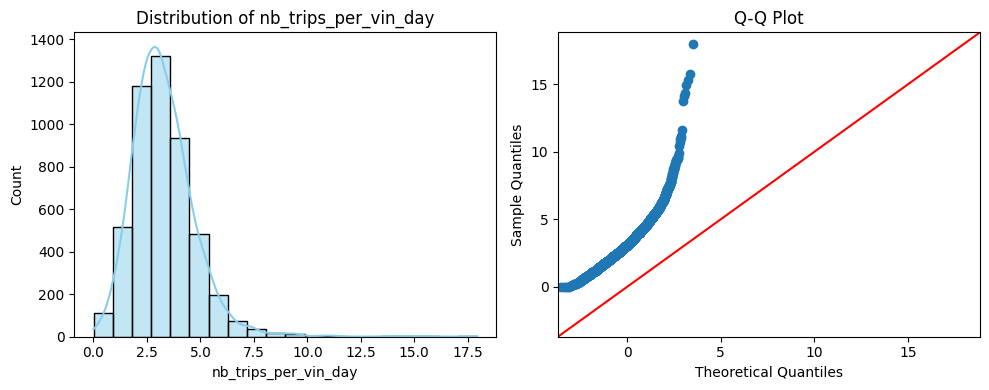

In [22]:
def calculate_distribution(df, column):
    # Descriptive statistics
    print(df[column].describe())
    
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(df[column].dropna())
    print(f"\nShapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")
    print("Data is normally distributed." if p_value > 0.05 else "Data is not normally distributed.")

    # Plotting
    plt.figure(figsize=(10, 4))
    
    # Histogram and KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {column}')
    
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    sm.qqplot(df[column].dropna(), line='45', ax=plt.gca())
    plt.title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

# Example usage
calculate_distribution(complete, 'nb_trips_per_vin_day')


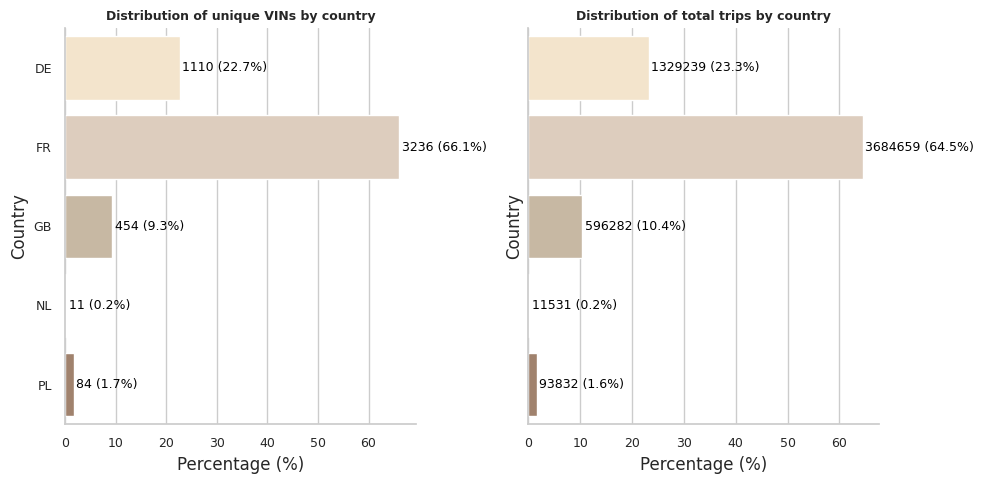

In [23]:
def plot_distributions(data1, data2, column1, column2, total1, total2, title1, title2, figsize=(10, 5)):
    # Define custom colors
    colors = ['#F9E5C6', '#E2CDB9', '#CDB99D', '#B9A881', '#A88165', '#946749']
    
    # Set seaborn style
    sns.set(style="whitegrid")
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)
    
    for ax, data, column, total, title in zip(axs, [data1, data2], [column1, column2], [total1, total2], [title1, title2]):
        # Prepare data
        category_count = data.groupby('country_reg').size().reset_index(name='count')
        categories = category_count['country_reg']
        quantities = category_count['count']
        percentages = [(q / total) * 100 for q in quantities]
        
        # Plot bar chart
        sns.barplot(x=percentages, y=categories, palette=colors, ax=ax)
        for i in range(len(categories)):
            ax.text(percentages[i] + 0.5, i, f'{quantities[i]} ({percentages[i]:.1f}%)', va='center', fontsize=9, color='black')
        ax.set_title(title, fontsize=9, fontweight='bold')
        ax.set_xlabel('Percentage (%)')
        ax.set_ylabel('Country')
        ax.tick_params(axis='both', which='major', labelsize=9)
        sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_distributions(
    dif_days, df_valid_trip,
    'country_reg', 'country_reg',
    dif_days.groupby('country_reg').size().sum(), 
    df_valid_trip.groupby('country_reg').size().sum(),
    'Distribution of unique VINs by country', 
    'Distribution of total trips by country'
)


# Confidence Interval

### Confidence Interval on all public

##### Confidence Interval for the Mean + Finite Population Correction (FPC) Method (Formula)

This method considers the Total Population (BFB_Total). If you do not know the size of the total population, you can use the standard approach to calculate the confidence interval for a sample mean. This is calculated using the Student's t-distribution, which accounts for the increased uncertainty due to estimating the variance from the sample.

Purpose: Adjusts the confidence interval for the mean, taking into account that the sample is a significant fraction of the total population. <br>
Calculation: The standard formula for the confidence interval of the mean is adjusted with a correction factor for the finite population.

In [24]:
# Define the variables
N = len(BFB_TOTAL)
n = len(complete.nb_trips_per_vin_day)
mean = np.mean(complete.nb_trips_per_vin_day)
sigma = math.sqrt(np.var(complete.nb_trips_per_vin_day, ddof=1))
alpha = 0.05
z = 1.96

# Method A: Calculate the finite population correction factor
f = math.sqrt((N-n)/(N-1))

# Calculate the confidence interval for method A
lower_bound_finite_pop = mean - z * (sigma / math.sqrt(n)) * f
upper_bound_finite_pop = mean + z * (sigma / math.sqrt(n)) * f

###### Analyzing the Confidence Interval acording of the decreasing of sampling values

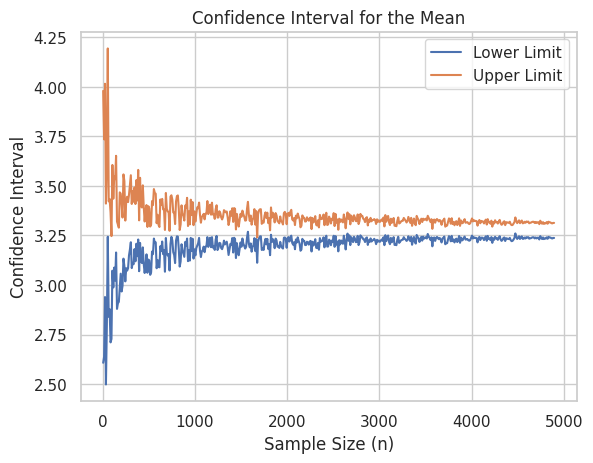

In [25]:
import random 
# Calculate and store the confidence interval for each sample size
n_values = []
lower_bounds = []
upper_bounds = []
for n in range(len(complete['nb_trips_per_vin_day']), 0, -10):
    # Randomly select n values from the 'quant' column of the table
    sample = random.sample(list(complete['nb_trips_per_vin_day']), n)
    
    # Calculate the mean and standard deviation of the selected sample
    sample_mean = np.mean(sample)
    sample_std_dev = np.std(sample, ddof=1)

    # Method A: Calculate the finite population correction factor
    f = math.sqrt((N-n)/(N-1))

    # Calculate the confidence interval for Method A
    lower_bound_finite_pop = sample_mean - z * (sample_std_dev / math.sqrt(n)) * f
    upper_bound_finite_pop = sample_mean + z * (sample_std_dev / math.sqrt(n)) * f
    
    n_values.append(n)
    lower_bounds.append(lower_bound_finite_pop)
    upper_bounds.append(upper_bound_finite_pop)

# Plot the confidence intervals on a graph
plt.plot(n_values, lower_bounds, label='Lower Limit')
plt.plot(n_values, upper_bounds, label='Upper Limit')
plt.xlabel('Sample Size (n)')
plt.ylabel('Confidence Interval')
plt.title('Confidence Interval for the Mean')
plt.legend()
plt.show()


##### Bootstrap

Purpose: Estimates the distribution of the sample mean through resampling with replacement and calculates the confidence interval based on the empirical distribution of the bootstrap means. <br>
Calculation: Generates multiple bootstrap samples from the original data, calculates the mean of each sample, and uses the percentiles of these means to obtain the confidence interval.

In [26]:
# Method B: Generate bootstrap samples
def bootstrap_mean(sample):
    return np.mean(sample)

bootstrap_means = [bootstrap_mean(complete['nb_trips_per_vin_day'].sample(n=len(complete), replace=True)) for i in range(1000)]

# Calculate confidence interval for method B
confidence_level = 0.95
lower_limit_bootstrap, upper_limit_bootstrap = np.percentile(bootstrap_means, [(1-confidence_level)/2*100, (1+confidence_level)/2*100])

##### Jakknife

Purpose: Estimates the variability of the sample mean by systematically leaving out one observation at a time and calculating the mean for each reduced sample. <br>
Calculation: Removes one observation at a time, calculates the mean for each reduced sample, and uses the variance of these means to compute the standard error and confidence interval.


In [27]:
# Method C: Calculate confidence interval using Jackknife
def mean_function(data):
    return np.mean(data)

BFB = [value for value in complete.nb_trips_per_vin_day]
n = len(BFB)

jackknife_means = []
for i in range(n):
    sample = BFB[:i] + BFB[i+1:]
    jackknife_means.append(mean_function(sample))
    
jackknife_means = np.array(jackknife_means)
mean_jackknife = np.mean(jackknife_means)
var_jackknife = ((n-1)/n) * np.sum((jackknife_means - mean_jackknife)**2)
std_error_jackknife = np.sqrt(var_jackknife)
lower_bound_jackknife = mean_jackknife - z*std_error_jackknife
upper_bound_jackknife = mean_jackknife + z*std_error_jackknife

##### Comparison

In [28]:
# Create and fill the comparative table
table = PrettyTable()
table.field_names = ["Method", "Confidence Interval"]
table.add_row(["Formula", "{} to {}".format(round(lower_bound_finite_pop, 2), round(upper_bound_finite_pop, 2))])
table.add_row(["Bootstrap", "{} to {}".format(round(lower_limit_bootstrap, 2), round(upper_limit_bootstrap, 2))])
table.add_row(["Jackknife", "{} to {}".format(round(lower_bound_jackknife, 2), round(upper_bound_jackknife, 2))])

# Display the table
print(table)

+-----------+---------------------+
|   Method  | Confidence Interval |
+-----------+---------------------+
|  Formula  |     2.61 to 3.98    |
| Bootstrap |     3.24 to 3.32    |
| Jackknife |     3.23 to 3.32    |
+-----------+---------------------+


### Confidence Interval on the percentiles

#### Bootstrap

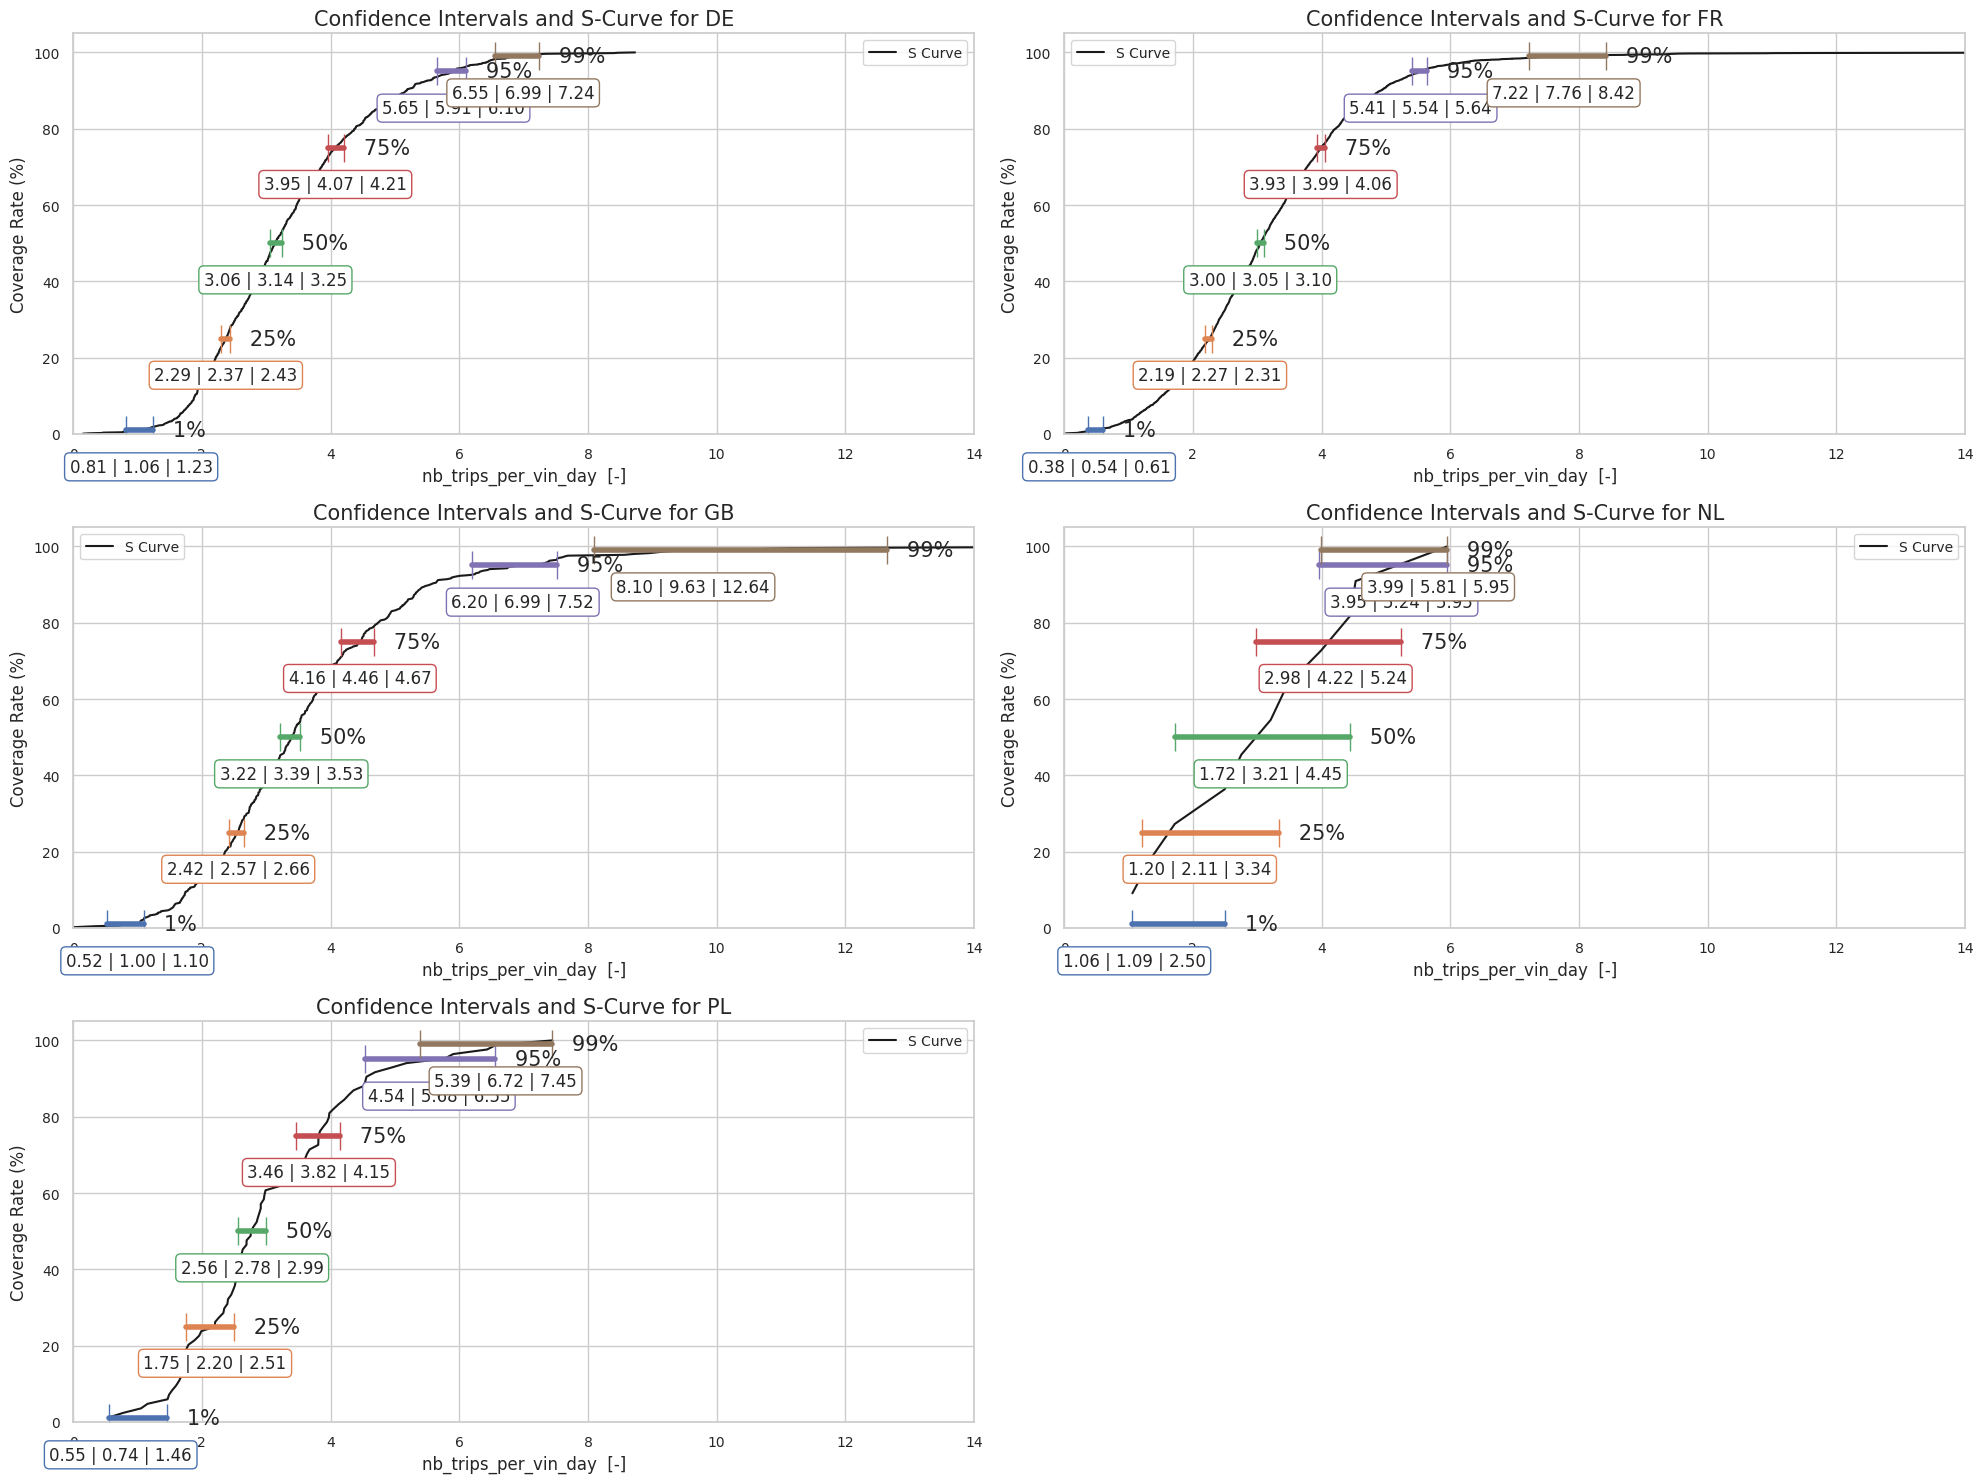

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

# Simplified functions
def calculate_cdf(data):
    sorted_data = np.sort(data)
    return sorted_data, [percentileofscore(sorted_data, value) for value in sorted_data]

def bootstrap_confidence_interval(data, percentiles=(1, 25, 50, 75, 95, 99), confidence=0.95, n_bootstraps=1000):
    bootstraps = [np.percentile(np.random.choice(data, size=len(data), replace=True), percentiles) for _ in range(n_bootstraps)]
    return {p: (np.percentile(bootstraps, (1-confidence)/2*100, axis=0)[i], 
                np.percentile(bootstraps, (1+confidence)/2*100, axis=0)[i]) for i, p in enumerate(percentiles)}

def plot_confidence_intervals(df, column, percentiles=[1, 25, 50, 75, 95, 99], confidence=0.95, n_bootstraps=1000):
    grouped = df.groupby('country_reg')
    n_countries = len(grouped)
    n_cols = 2
    n_rows = (n_countries + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axs = axs.flatten()

    for i, (country, group) in enumerate(grouped):
        data = group[column]
        sorted_data, cdf = calculate_cdf(data)
        intervals = bootstrap_confidence_interval(data, percentiles, confidence, n_bootstraps)
        ax = axs[i]
        
        # S-curve plot
        ax.plot(sorted_data, cdf, color='k', label='S Curve')
        
        # Confidence intervals and percentiles
        for j, p in enumerate(percentiles):
            interval = intervals[p]
            percentile_value = np.percentile(data, p)
            ax.plot(interval, [p, p], '|-', markersize=20, color=f'C{j}', linewidth=4)
            ax.text(interval[1], p, f'   {p}% ', fontsize=15, verticalalignment='center')
            ax.annotate(f'{interval[0]:.2f} | {percentile_value:.2f} | {interval[1]:.2f}', 
                        (percentile_value, p), textcoords="offset points", xytext=(0, -30), ha='center', 
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor=f'C{j}', facecolor="white"))

        # Axis limits, labels, and titles
        ax.set_xlim(0, 14)
        ax.set_ylim(0, 105)
        ax.set_xlabel('nb_trips_per_vin_day  [-]', fontsize=12)
        ax.set_ylabel('Coverage Rate (%)', fontsize=12)
        ax.set_title(f'Confidence Intervals and S-Curve for {country}', fontsize=15)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True)
        ax.tick_params(axis='both', labelsize=10)

    # Turn off unused subplots
    for i in range(n_countries, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot the graphs with two columns per row
plot_confidence_intervals(complete, 'nb_trips_per_vin_day', percentiles=[1, 25, 50, 75, 95, 99])


#### Selecting the worst case

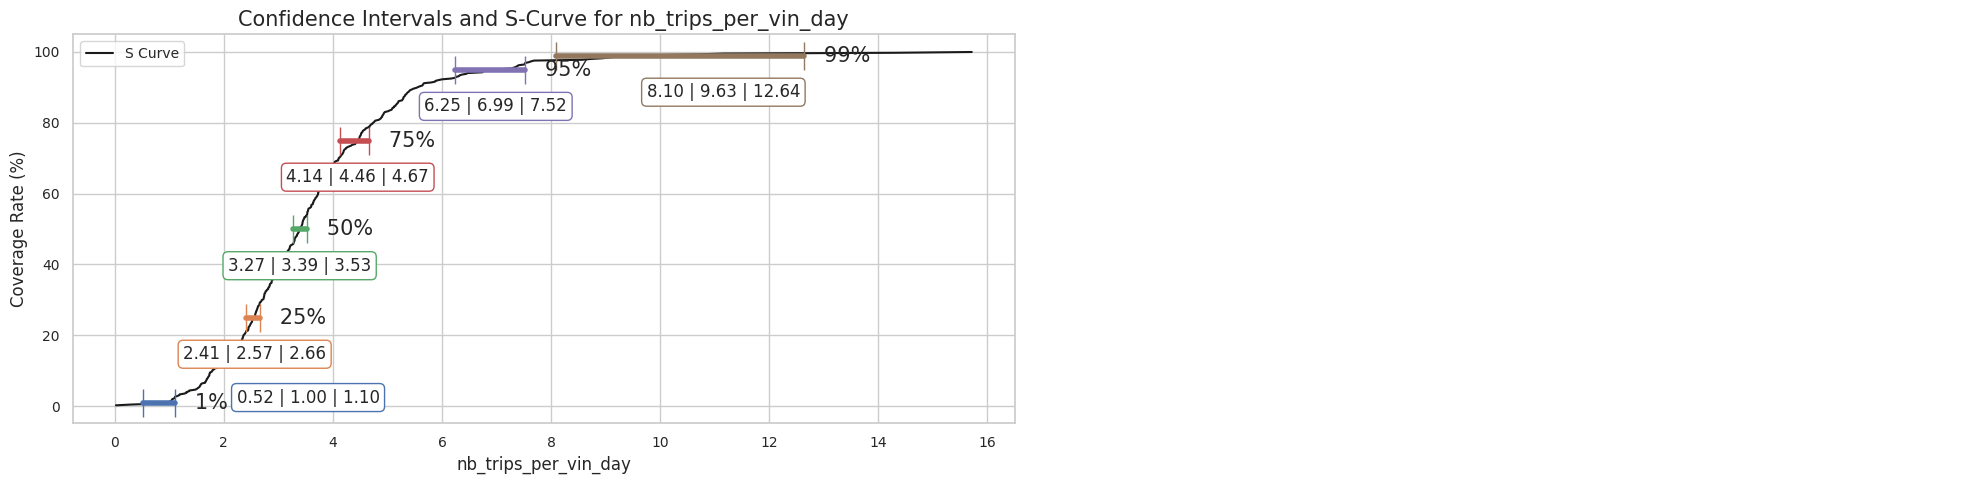

In [35]:
plot_confidence_intervals(complete[complete['country_reg'] == 'GB'], 'nb_trips_per_vin_day', percentiles=[1, 25, 50, 75, 95, 99])

##### Ploting the distribution for each percentile, in order to understand the behavior of the confidence interval

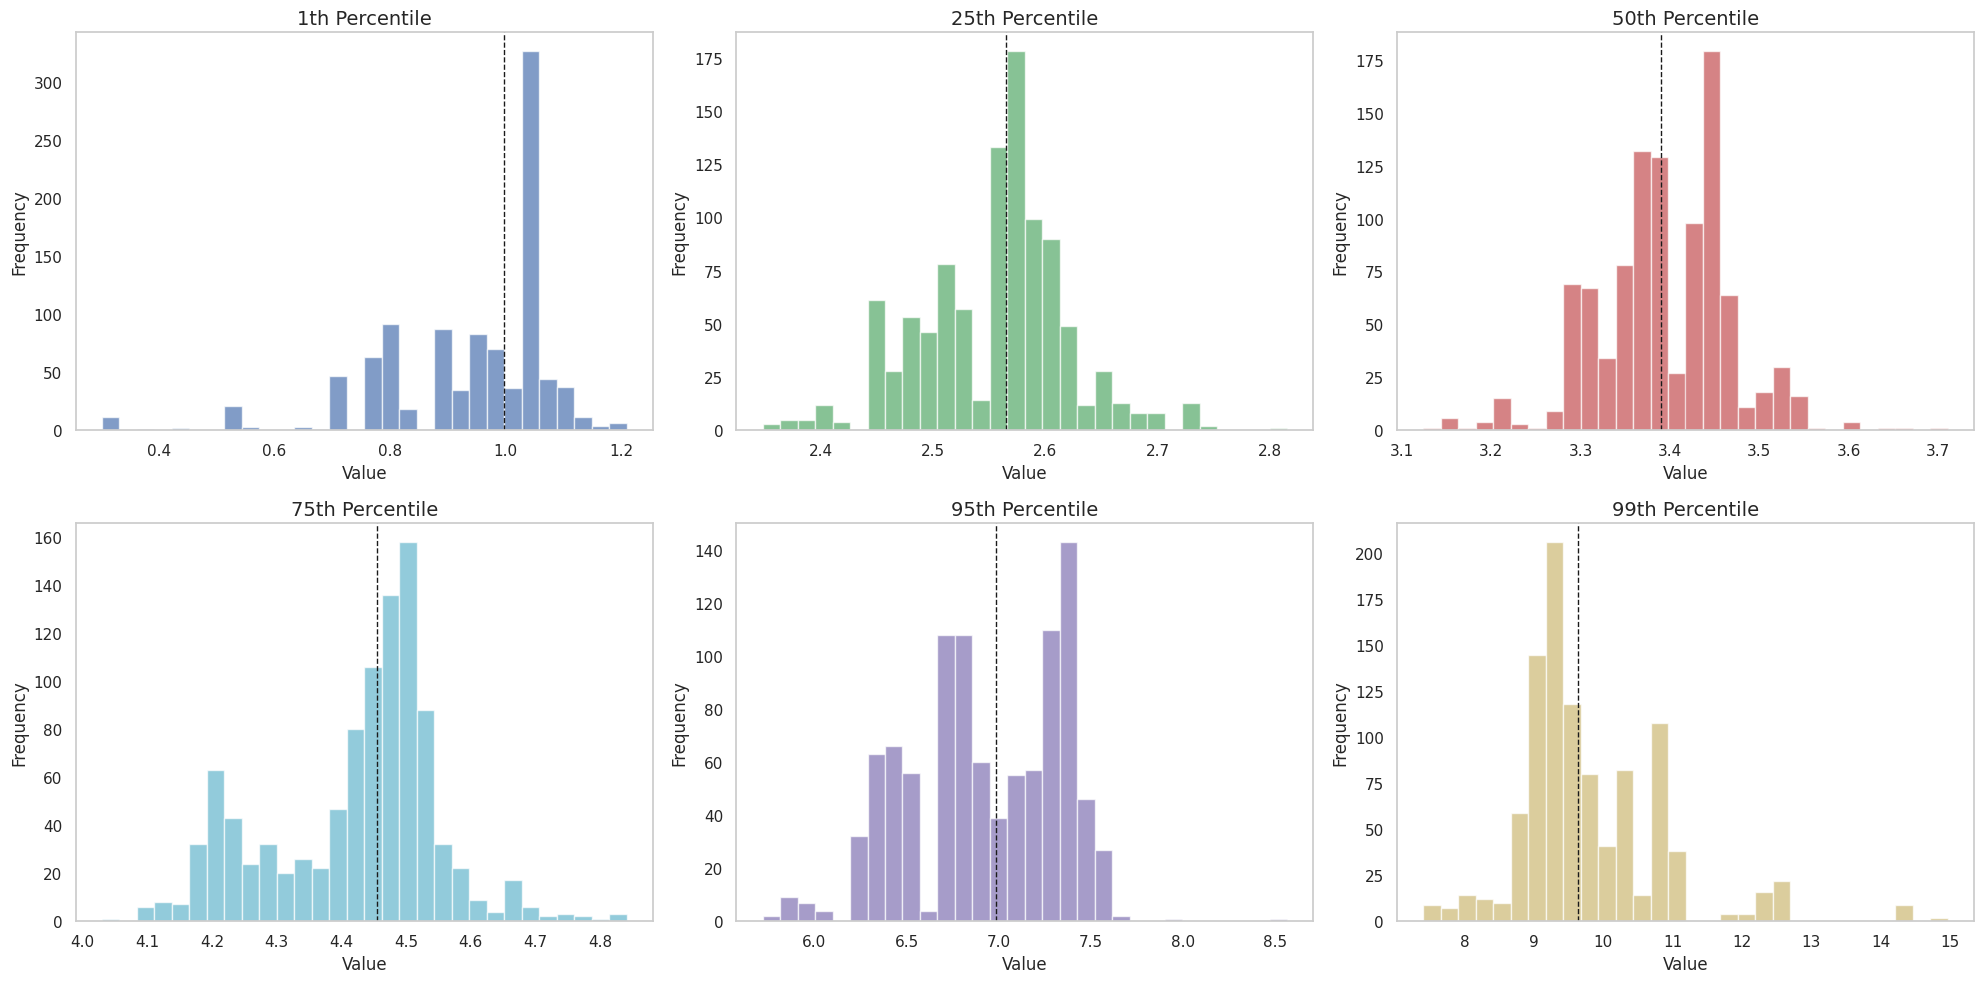

In [42]:
def plot_bootstrap_distributions(df, column, percentiles=[1, 25, 50, 75, 95, 99], confidence=0.95, n_bootstraps=1000, colors=['b', 'g', 'r', 'c', 'm', 'y']):
    # Filter the data for the specific column
    data = df[column]

    # Generate bootstrap samples and calculate percentiles for each bootstrap
    bootstrapped_percentiles = {p: [] for p in percentiles}
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        for p in percentiles:
            bootstrapped_percentiles[p].append(np.percentile(bootstrap_sample, p))

    # Determine the number of rows and columns needed for the subplots
    n_cols = 3
    n_rows = (len(percentiles) + n_cols - 1) // n_cols

    # Plot the distributions of the bootstrap percentiles
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

    for i, p in enumerate(percentiles):
        ax = axs[i]
        # Plot histogram of the bootstrap percentiles
        ax.hist(bootstrapped_percentiles[p], bins=30, color=colors[i % len(colors)], alpha=0.7)
        # Add a vertical line for the actual percentile value from the original data
        ax.axvline(np.percentile(data, p), color='k', linestyle='dashed', linewidth=1)
        ax.set_title(f'{p}th Percentile', fontsize=14)
        ax.set_xlabel('Value', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        # Remove grid lines
        ax.grid(False)

    # Turn off unused subplots if there are any
    for i in range(len(percentiles), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for a specific country, e.g., GB
filtered_country = complete[complete['country_reg'] == 'GB']
plot_bootstrap_distributions(filtered_country, 'nb_trips_per_vin_day', percentiles=[1, 25, 50, 75, 95, 99])
